<h3> Step 1 - Importiing Libraries </h3>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 
import time
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, classification_report   
from sklearn.ensemble import ExtraTreesClassifier

<h3> Step 2 - Loading Datasets </h3>

In [5]:
# Define column names for the KDD dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count',
    'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

# Load datasets
train_path =r"C:\Users\lenovo\Desktop\SentinelNet\Datasets\nsl-kdd\KDDTrain+.txt"
test_path =r"C:\Users\lenovo\Desktop\SentinelNet\Datasets\nsl-kdd\KDDTest+.txt"

train_df = pd.read_csv(train_path, delimiter=",", names=columns)
test_df = pd.read_csv(test_path, delimiter=",", names=columns)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Drop difficulty_level column
train_df.drop(['difficulty_level'], axis=1, inplace=True)
test_df.drop(['difficulty_level'], axis=1, inplace=True)

print("New Train shape:", train_df.shape)
print("New Test shape:", test_df.shape)

Train set shape: (125973, 43)
Test set shape: (22544, 43)
New Train shape: (125973, 42)
New Test shape: (22544, 42)


<h3> Step 3 - Aligning datasets </h3>

In [6]:
# Display unique attack labels in train and test sets
print("\nUnique labels in train set:\n", train_df.iloc[:, -1].unique())
print("\nUnique labels in test set:\n", test_df.iloc[:, -1].unique())

# Align datasets to have common classes only
common_classes = set(train_df.iloc[:, -1]).intersection(set(test_df.iloc[:, -1]))

train_df = train_df[train_df.iloc[:, -1].isin(common_classes)]
test_df = test_df[test_df.iloc[:, -1].isin(common_classes)]

print("\nAligned unique labels in train set:\n", train_df.iloc[:, -1].unique())
print("\nAligned unique labels in test set:\n", test_df.iloc[:, -1].unique())

print("\nTrain set class distribution:\n", train_df['label'].value_counts())


Unique labels in train set:
 ['normal' 'neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap'
 'satan' 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop'
 'rootkit' 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land'
 'loadmodule' 'spy' 'perl']

Unique labels in test set:
 ['neptune' 'normal' 'saint' 'mscan' 'guess_passwd' 'smurf' 'apache2'
 'satan' 'buffer_overflow' 'back' 'warezmaster' 'snmpgetattack'
 'processtable' 'pod' 'httptunnel' 'nmap' 'ps' 'snmpguess' 'ipsweep'
 'mailbomb' 'portsweep' 'multihop' 'named' 'sendmail' 'loadmodule' 'xterm'
 'worm' 'teardrop' 'rootkit' 'xlock' 'perl' 'land' 'xsnoop' 'sqlattack'
 'ftp_write' 'imap' 'udpstorm' 'phf']

Aligned unique labels in train set:
 ['normal' 'neptune' 'ipsweep' 'portsweep' 'teardrop' 'nmap' 'satan'
 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop' 'rootkit'
 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land' 'loadmodule' 'perl']

Aligned unique labels in test set:
 ['neptune' 'normal' 'guess_passwd'

In [7]:
# Check class distribution in train and test sets
print("\nTrain set class distribution:\n", train_df['label'].value_counts())
print("\nTest set class distribution:\n", test_df['label'].value_counts())



Train set class distribution:
 label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
Name: count, dtype: int64

Test set class distribution:
 label
normal             9711
neptune            4657
guess_passwd       1231
warezmaster         944
satan               735
smurf               665
back                359
portsweep           157
ipsweep             141
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
rootkit              13
teardrop             12
land          

<h3> Step 4 - Grouping rare classes into other </h3>

In [8]:
# Identify attack classes with low sample counts below threshold
# Group these rare classes under a single 'OTHER' category to reduce label sparsity

# Process train set
class_counts = train_df['label'].value_counts()
threshold = 21
rare_classes = class_counts[class_counts < threshold].index.tolist()
print("Rare classes in train set grouped into OTHER:", rare_classes, "\n")

train_df.loc[:, 'label'] = train_df['label'].apply(lambda x: 'OTHER' if x in rare_classes else x)
print("Updated train set class distribution:\n", train_df['label'].value_counts(), "\n")

# Process test set
class_counts = test_df['label'].value_counts()
threshold = 20
rare_classes = class_counts[class_counts < threshold].index.tolist()
print("Rare classes in test set grouped into OTHER:", rare_classes, "\n")

test_df.loc[:, 'label'] = test_df['label'].apply(lambda x: 'OTHER' if x in rare_classes else x)
print("Updated test set class distribution:\n", test_df['label'].value_counts(), "\n")

Rare classes in train set grouped into OTHER: ['warezmaster', 'land', 'imap', 'rootkit', 'loadmodule', 'ftp_write', 'multihop', 'phf', 'perl'] 

Updated train set class distribution:
 label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
pod                  201
OTHER                 90
guess_passwd          53
buffer_overflow       30
Name: count, dtype: int64 

Rare classes in test set grouped into OTHER: ['multihop', 'rootkit', 'teardrop', 'land', 'ftp_write', 'perl', 'loadmodule', 'phf', 'imap'] 

Updated test set class distribution:
 label
normal             9711
neptune            4657
guess_passwd       1231
warezmaster         944
satan               735
smurf               665
back                359
portsweep           157
ipsweep             141
nmap                 73
OTHER                60
pod     

<h3> Step 5 - Data cleaning </h3>

In [9]:
# Basic Data Cleaning
print("=== Basic Data Cleaning ===")

# Check and remove duplicates
train_before = train_df.shape[0]
test_before = test_df.shape[0]

train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

train_after = train_df.shape[0]
test_after = test_df.shape[0]

print(f"Train set: {train_before} → {train_after} rows (removed {train_before - train_after} duplicates)")
print(f"Test set: {test_before} → {test_after} rows (removed {test_before - test_after} duplicates)")
print("Data cleaning completed.\n")

=== Basic Data Cleaning ===
Train set: 125081 → 125081 rows (removed 0 duplicates)
Test set: 18794 → 18794 rows (removed 0 duplicates)
Data cleaning completed.



<h3> Step 6 - Creating binary target </h3>

In [10]:
# Create binary target 'attack_binary' where 0 = Normal, 1 = Attack
train_df.loc[:, 'attack_binary'] = train_df['label'].apply(lambda x: 0 if x.lower() == 'normal' else 1)
test_df.loc[:, 'attack_binary'] = test_df['label'].apply(lambda x: 0 if x.lower() == 'normal' else 1)

class_dist = train_df['attack_binary'].value_counts(normalize=True) * 100
print("Class Distribution in Train Set (%):\n", class_dist, "\n")
print("Class Counts in Train Set:\n", train_df['attack_binary'].value_counts())

Class Distribution in Train Set (%):
 attack_binary
0    53.839512
1    46.160488
Name: proportion, dtype: float64 

Class Counts in Train Set:
 attack_binary
0    67343
1    57738
Name: count, dtype: int64


<h3> Step 7 -  Exploratory Data Analysis (EDA) </h3>

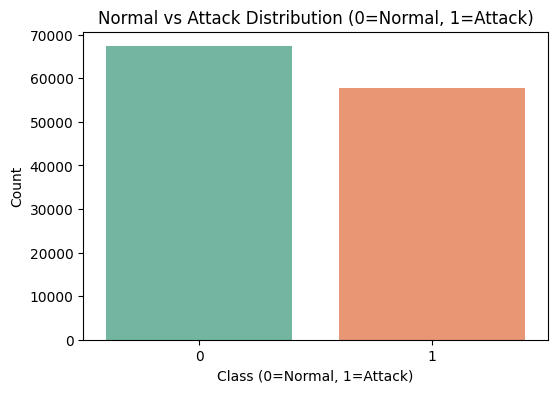

In [11]:
# Normal vs Attack distribution plot 

plt.figure(figsize=(6,4))
sns.countplot(x='attack_binary', data=train_df, hue='attack_binary', palette="Set2", dodge=False, legend=False)
plt.title("Normal vs Attack Distribution (0=Normal, 1=Attack)", fontsize=12)
plt.xlabel("Class (0=Normal, 1=Attack)")
plt.ylabel("Count")
plt.show()


<h3> Step 8 - Top 10 attack categories </h3>

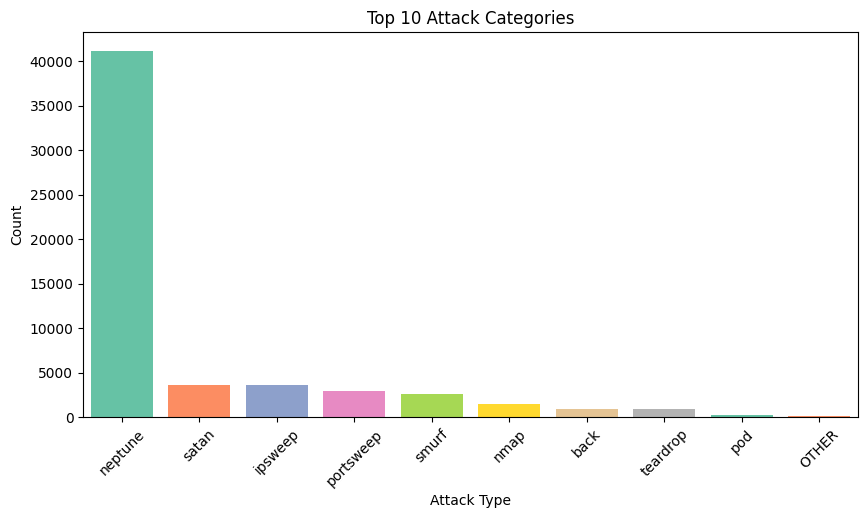

In [12]:
# Top 10 attack categories

attack_counts = train_df[train_df['label'] != 'normal']['label'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=attack_counts.index, y=attack_counts.values) 

colors = sns.color_palette("Set2", len(attack_counts))
for i, bar in enumerate(plt.gca().patches):
    bar.set_facecolor(colors[i])

plt.title("Top 10 Attack Categories", fontsize=12)
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [13]:
print(train_df.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'attack_binary'],
      dtype='object')


<h3> Step 9 - Identify feature types and preprocessing strategy </h3> 

In [14]:
# Identify categorical and numerical features
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['protocol_type', 'service', 'flag', 'label']
Numerical Features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_binary']


In [15]:
# Identify categorical and numerical features
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(exclude=['object']).columns.tolist()
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['protocol_type', 'service', 'flag', 'label']
Numerical Features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_binary']


In [16]:
# Define feature groups and label mappings
# Infer feature types and recommend preprocessing steps like encoding or scaling
# Build and display a schema table summarizing this information

binary = {"land", "logged_in", "root_shell", "su_attempted", "is_host_login", "is_guest_login"}
drop = {"num_outbound_cmds", "is_host_login"}  # columns to drop
special = {"src_bytes": "Log-transform + Normalize", "dst_bytes": "Log-transform + Normalize"}
labels = {"outcome": "Label encode", "attack_binary": "Already created", "attack_multi": "Already created"}

def infer_type(col, s):
    if col in binary:
        return "Binary"
    if s.dtype == "object":
        return "Categorical"
    return "Numerical"

def preprocessing(col, t):
    if col in drop:
        return "Drop"
    if col in special:
        return special[col]
    if col in labels:
        return labels[col]
    if t == "Binary":
        return "Keep as is (0/1)"
    if t == "Categorical":
        return "One-hot encode / Label encode"
    if t == "Numerical":
        return "Already normalized" if "_rate" in col else "Normalize/Standardize"
    return "Check"

schema = [{
    "Feature": c,
    "Type": infer_type(c, train_df[c]),
    "Preprocessing": preprocessing(c, infer_type(c, train_df[c])),
    "Semantic": "Label" if c in ["outcome", "attack_binary", "attack_multi"] else "Feature"
} for c in train_df.columns]

schema_df = pd.DataFrame(schema)
display(schema_df)

,Feature,Type,Preprocessing,Semantic
0,duration,Numerical,Normalize/Standardize,Feature
1,protocol_type,Categorical,One-hot encode / Label encode,Feature
2,service,Categorical,One-hot encode / Label encode,Feature
3,flag,Categorical,One-hot encode / Label encode,Feature
4,src_bytes,Numerical,Log-transform + Normalize,Feature
5,dst_bytes,Numerical,Log-transform + Normalize,Feature
6,land,Binary,Keep as is (0/1),Feature
7,wrong_fragment,Numerical,Normalize/Standardize,Feature
8,urgent,Numerical,Normalize/Standardize,Feature
9,hot,Numerical,Normalize/Standardize,Feature


In [17]:
# Drop unneeded columns if present
# Remove duplicate rows to avoid bias
# Print dataset shapes after cleanup

print("Train columns:", train_df.columns.tolist())

# Remove duplicates
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

print("Train shape after cleanup:", train_df.shape)
print("Test shape after cleanup:", test_df.shape)

Train columns: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'attack_binary']
Train shape after cleanup: (125081, 43)
Test shape after cleanup: (18794, 43)


<h3> Step 10 - One Hot Encoding </h3>

In [18]:
# One-Hot Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']

train_df_encoded = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align test set columns with train set
missing_cols = set(train_df_encoded.columns) - set(test_df_encoded.columns)
for col in missing_cols:
    test_df_encoded[col] = 0

# Reorder columns to match
test_df_encoded = test_df_encoded[train_df_encoded.columns]

print("Train shape after One-Hot Encoding:", train_df_encoded.shape)
print("Test shape after One-Hot Encoding:", test_df_encoded.shape)

Train shape after One-Hot Encoding: (125081, 121)
Test shape after One-Hot Encoding: (18794, 121)


In [19]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 125081 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125081 non-null  int64  
 1   protocol_type                125081 non-null  object 
 2   service                      125081 non-null  object 
 3   flag                         125081 non-null  object 
 4   src_bytes                    125081 non-null  int64  
 5   dst_bytes                    125081 non-null  int64  
 6   land                         125081 non-null  int64  
 7   wrong_fragment               125081 non-null  int64  
 8   urgent                       125081 non-null  int64  
 9   hot                          125081 non-null  int64  
 10  num_failed_logins            125081 non-null  int64  
 11  logged_in                    125081 non-null  int64  
 12  num_compromised              125081 non-null  int64  
 13  root

In [20]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18794 entries, 0 to 22542
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     18794 non-null  int64  
 1   protocol_type                18794 non-null  object 
 2   service                      18794 non-null  object 
 3   flag                         18794 non-null  object 
 4   src_bytes                    18794 non-null  int64  
 5   dst_bytes                    18794 non-null  int64  
 6   land                         18794 non-null  int64  
 7   wrong_fragment               18794 non-null  int64  
 8   urgent                       18794 non-null  int64  
 9   hot                          18794 non-null  int64  
 10  num_failed_logins            18794 non-null  int64  
 11  logged_in                    18794 non-null  int64  
 12  num_compromised              18794 non-null  int64  
 13  root_shell           

<h3> Step 11 - Feature Scaling </h3>

In [21]:
# Identify numeric features excluding labels and apply Min-Max scaling
exclude_cols = ['label', 'attack_binary']
numeric_cols = train_df_encoded.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# Initialize and fit scaler
scaler = MinMaxScaler()
train_df_encoded[numeric_cols] = scaler.fit_transform(train_df_encoded[numeric_cols])
test_df_encoded[numeric_cols] = scaler.transform(test_df_encoded[numeric_cols])

print("Numeric features scaled using MinMaxScaler.")
print(f"Number of numeric features scaled: {len(numeric_cols)}")

Numeric features scaled using MinMaxScaler.
Number of numeric features scaled: 38


<h3> Step 12 - Preparing features and target </h3>

In [22]:
# Prepare features and target for binary classification
exclude_cols = ['attack_binary', 'label']

X_train_full = train_df_encoded.drop(columns=exclude_cols)
y_train_full = train_df_encoded['attack_binary']

X_test_final = test_df_encoded.drop(columns=exclude_cols)
y_test_final = test_df_encoded['attack_binary']

print("Training features shape:", X_train_full.shape)
print("Test features shape:", X_test_final.shape)
print("Class distribution in training:", y_train_full.value_counts())

Training features shape: (125081, 119)
Test features shape: (18794, 119)
Class distribution in training: attack_binary
0    67343
1    57738
Name: count, dtype: int64


<h3> Step 13 - Test-train split with stratification </h3>

In [23]:
# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Training class distribution:")
print(y_train.value_counts(normalize=True))

Training set shape: (100064, 119)
Validation set shape: (25017, 119)
Training class distribution:
attack_binary
0    0.538395
1    0.461605
Name: proportion, dtype: float64


<h3> Step 14 - Applying SMOTETOmek </h3>

In [24]:
# Apply SMOTETomek to balance the training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("Class distribution after SMOTETomek:")
print(pd.Series(y_train_resampled).value_counts())
print(f"Resampled training shape: {X_train_resampled.shape}")

Class distribution after SMOTETomek:
attack_binary
0    53842
1    53842
Name: count, dtype: int64
Resampled training shape: (107684, 119)


<h3> Step 15 - Initialize Model </h3>

In [25]:
# Define models with original specifications
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        C=1.0, 
        solver='liblinear'
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42, 
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6
    )
}

<h3> Step 16 - Binary Classification </h3>

In [26]:
# Model validation function with comprehensive metrics
def validate_models(models, X_train, y_train, X_val, y_val):
    print("\n=== Binary Classification Validation ===")
    validation_results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()
        
        # Fit model
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Validation predictions
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        # Training predictions (to check overfitting)
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        
        # Calculate specificity
        cm = confusion_matrix(y_val, y_val_pred)
        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
            specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
            sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        else:
            specificity = sensitivity = 0
        
        # Store results
        validation_results[name] = {
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy,
            'specificity': specificity,
            'sensitivity': sensitivity,
            'training_time': training_time
        }
        
        # Print results
        print(f"{name} Results:")
        print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
        print(f"  Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Training Time: {training_time:.2f} seconds")
        print(f"  Overfitting Check: {abs(train_accuracy - val_accuracy):.4f}")
        
    return validation_results

# Run validation
validation_results = validate_models(models, X_train_resampled, y_train_resampled, X_val, y_val)


=== Binary Classification Validation ===

Training Logistic Regression...
Logistic Regression Results:
  Training Accuracy: 0.9785 (97.85%)
  Validation Accuracy: 0.9776 (97.76%)
  Specificity: 0.9840
  Sensitivity: 0.9700
  Training Time: 2.85 seconds
  Overfitting Check: 0.0009

Training Decision Tree...
Decision Tree Results:
  Training Accuracy: 0.9984 (99.84%)
  Validation Accuracy: 0.9977 (99.77%)
  Specificity: 0.9977
  Sensitivity: 0.9977
  Training Time: 1.66 seconds
  Overfitting Check: 0.0007

Training Random Forest...
Random Forest Results:
  Training Accuracy: 0.9993 (99.93%)
  Validation Accuracy: 0.9984 (99.84%)
  Specificity: 0.9996
  Sensitivity: 0.9971
  Training Time: 5.31 seconds
  Overfitting Check: 0.0009

Training Gradient Boosting...
Gradient Boosting Results:
  Training Accuracy: 0.9999 (99.99%)
  Validation Accuracy: 0.9988 (99.88%)
  Specificity: 0.9990
  Sensitivity: 0.9986
  Training Time: 120.53 seconds
  Overfitting Check: 0.0010


<h3> Step 17 - Training and testing evaluation </h3>

In [27]:
# Final test evaluation function
def evaluate_final_test(models, X_train, y_train, X_test, y_test):
    print("\n=== Final Test Evaluation ===")
    test_results = {}
    
    for name, model in models.items():
        print(f"\nEvaluating {name} on test set...")
        
        # Train on full resampled data
        model.fit(X_train, y_train)
        
        # Test predictions
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # Store results
        test_results[name] = test_accuracy
        
        print(f"{name} Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        
        # Classification report
        print(f"\n{name} Classification Report:")
        print(classification_report(y_test, y_test_pred))
        
    return test_results

# Run final test evaluation
test_results = evaluate_final_test(models, X_train_resampled, y_train_resampled, X_test_final, y_test_final)


=== Final Test Evaluation ===

Evaluating Logistic Regression on test set...
Logistic Regression Test Accuracy: 0.8188 (81.88%)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      9711
           1       0.89      0.71      0.79      9083

    accuracy                           0.82     18794
   macro avg       0.83      0.82      0.82     18794
weighted avg       0.83      0.82      0.82     18794


Evaluating Decision Tree on test set...
Decision Tree Test Accuracy: 0.8648 (86.48%)

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      9711
           1       0.96      0.75      0.84      9083

    accuracy                           0.86     18794
   macro avg       0.88      0.86      0.86     18794
weighted avg       0.88      0.86      0.86     18794


Evaluating Random Forest on test set...
Random F

<h3> Step 18 -  Model Accuracy Comparision  </h3>

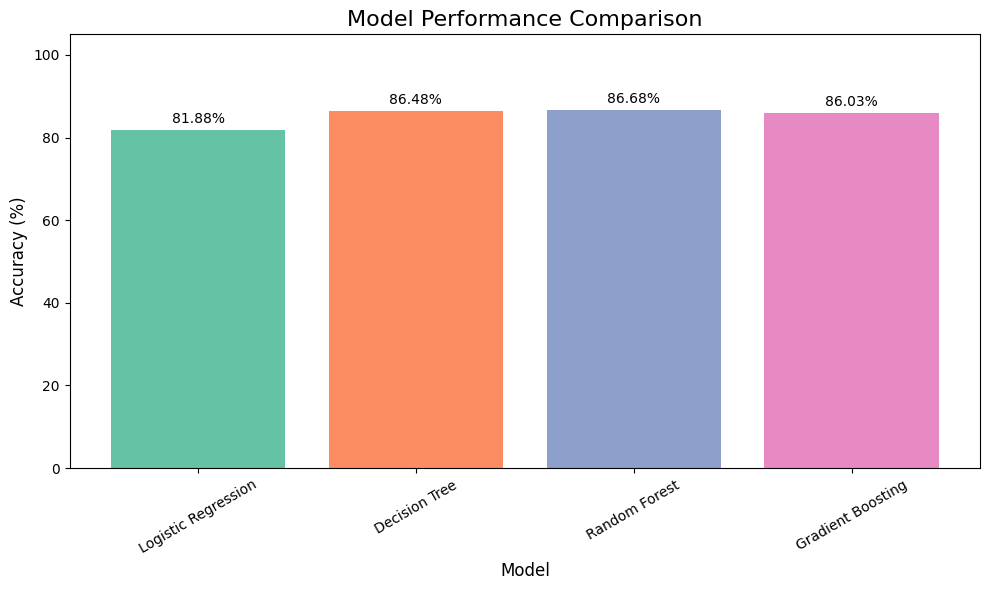


=== Performance Summary ===
Logistic Regression: 81.88%
Decision Tree: 86.48%
Random Forest: 86.68%
Gradient Boosting: 86.03%


In [29]:
# Visualize model performance comparison with Set2 colors
results_df = pd.DataFrame([
    {'Model': name, 'Accuracy': acc * 100} 
    for name, acc in test_results.items()
])

plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['Model'], results_df['Accuracy'])

# Apply Set2 colors manually
colors = sns.color_palette("Set2", len(results_df))
for i, bar in enumerate(bars):
    bar.set_facecolor(colors[i])

plt.title('Model Performance Comparison', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 105)
plt.xticks(rotation=30)

# Add accuracy labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary without target check
print("\n=== Performance Summary ===")
for name, acc in test_results.items():
    print(f"{name}: {acc*100:.2f}%")

<h3> Step 19 - Confusion Matrix (Random Forest) </h3>


=== Best Model: Random Forest ===
Test Accuracy: 0.8668 (86.68%)


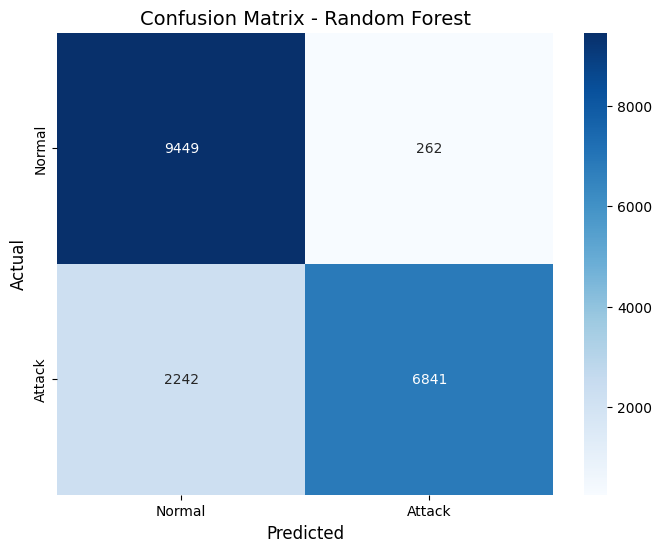


Detailed Metrics for Random Forest:
True Negatives (Normal correctly identified): 9449
False Positives (Normal misclassified as Attack): 262
False Negatives (Attack misclassified as Normal): 2242
True Positives (Attack correctly identified): 6841

Calculated Metrics:
Accuracy: 0.8668 (86.68%)
Precision: 0.9631
Recall (Sensitivity): 0.7532
Specificity: 0.9730


In [30]:
# Detailed analysis of the best performing model
best_model_name = max(test_results.keys(), key=lambda k: test_results[k])
best_model = models[best_model_name]
best_accuracy = test_results[best_model_name]

print(f"\n=== Best Model: {best_model_name} ===")
print(f"Test Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Train the best model
best_model.fit(X_train_resampled, y_train_resampled)

# Generate predictions
y_pred_best = best_model.predict(X_test_final)

# Confusion Matrix
cm = confusion_matrix(y_test_final, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

# Calculate metrics from confusion matrix
if cm.shape == (2, 2):
    TN, FP, FN, TP = cm.ravel()
    
    print(f"\nDetailed Metrics for {best_model_name}:")
    print(f"True Negatives (Normal correctly identified): {TN}")
    print(f"False Positives (Normal misclassified as Attack): {FP}")
    print(f"False Negatives (Attack misclassified as Normal): {FN}")
    print(f"True Positives (Attack correctly identified): {TP}")
    
    accuracy_cm = (TN + TP) / (TN + FP + FN + TP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    print(f"\nCalculated Metrics:")
    print(f"Accuracy: {accuracy_cm:.4f} ({accuracy_cm*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")

<h3> Step 20 - ROC Curve and AUC Analysis </h3>

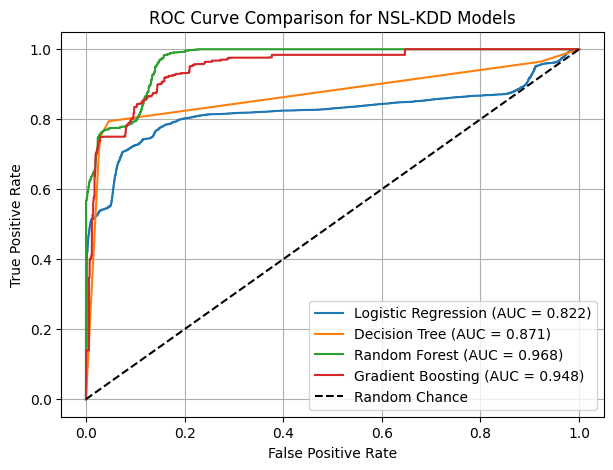

In [31]:
plt.figure(figsize=(7, 5))

for name, model in models.items():
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict probabilities on the test set
    y_probs = model.predict_proba(X_test_final)[:, 1]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_final, y_probs)
    auc_score = roc_auc_score(y_test_final, y_probs)
    
    # Plot ROC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

# Random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve Comparison for NSL-KDD Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<h3> Step 21 - Box Plot </h3>

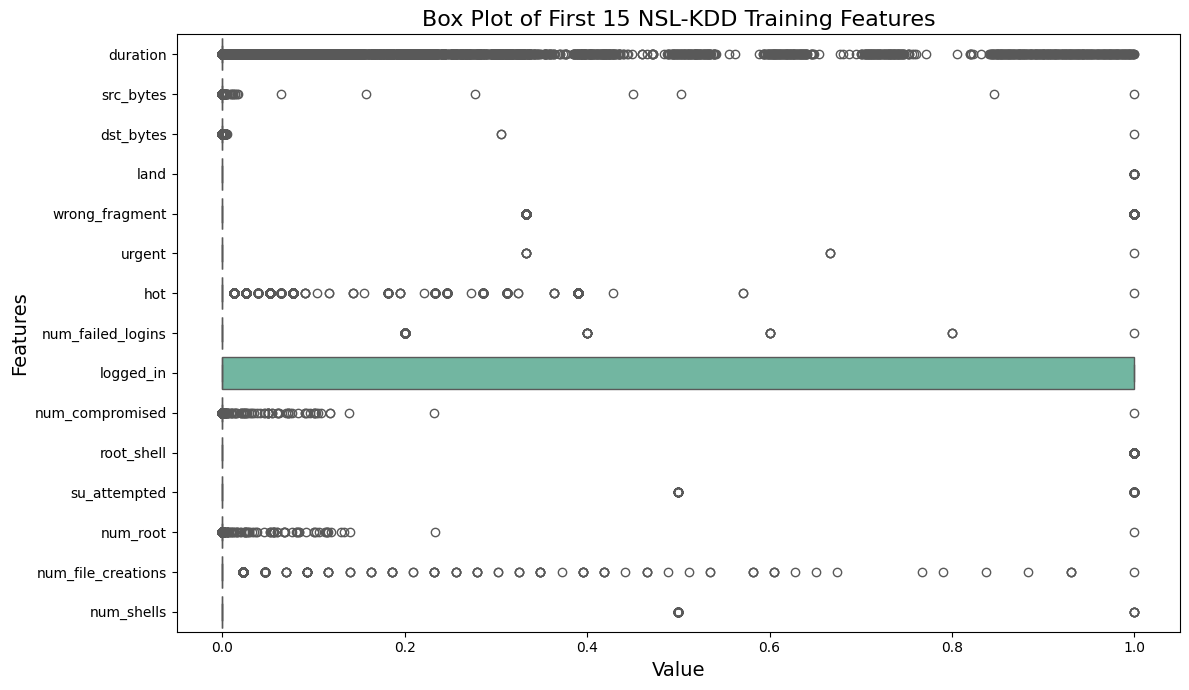

In [32]:
n_features = 15  
selected_cols = X_train_full.columns[:n_features]

plt.figure(figsize=(12, 7))
sns.boxplot(data=X_train_full[selected_cols], orient='h', palette="Set2")
plt.title(f'Box Plot of First {n_features} NSL-KDD Training Features', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

<h3> Step 22 - Correlation HeatMap </h3>

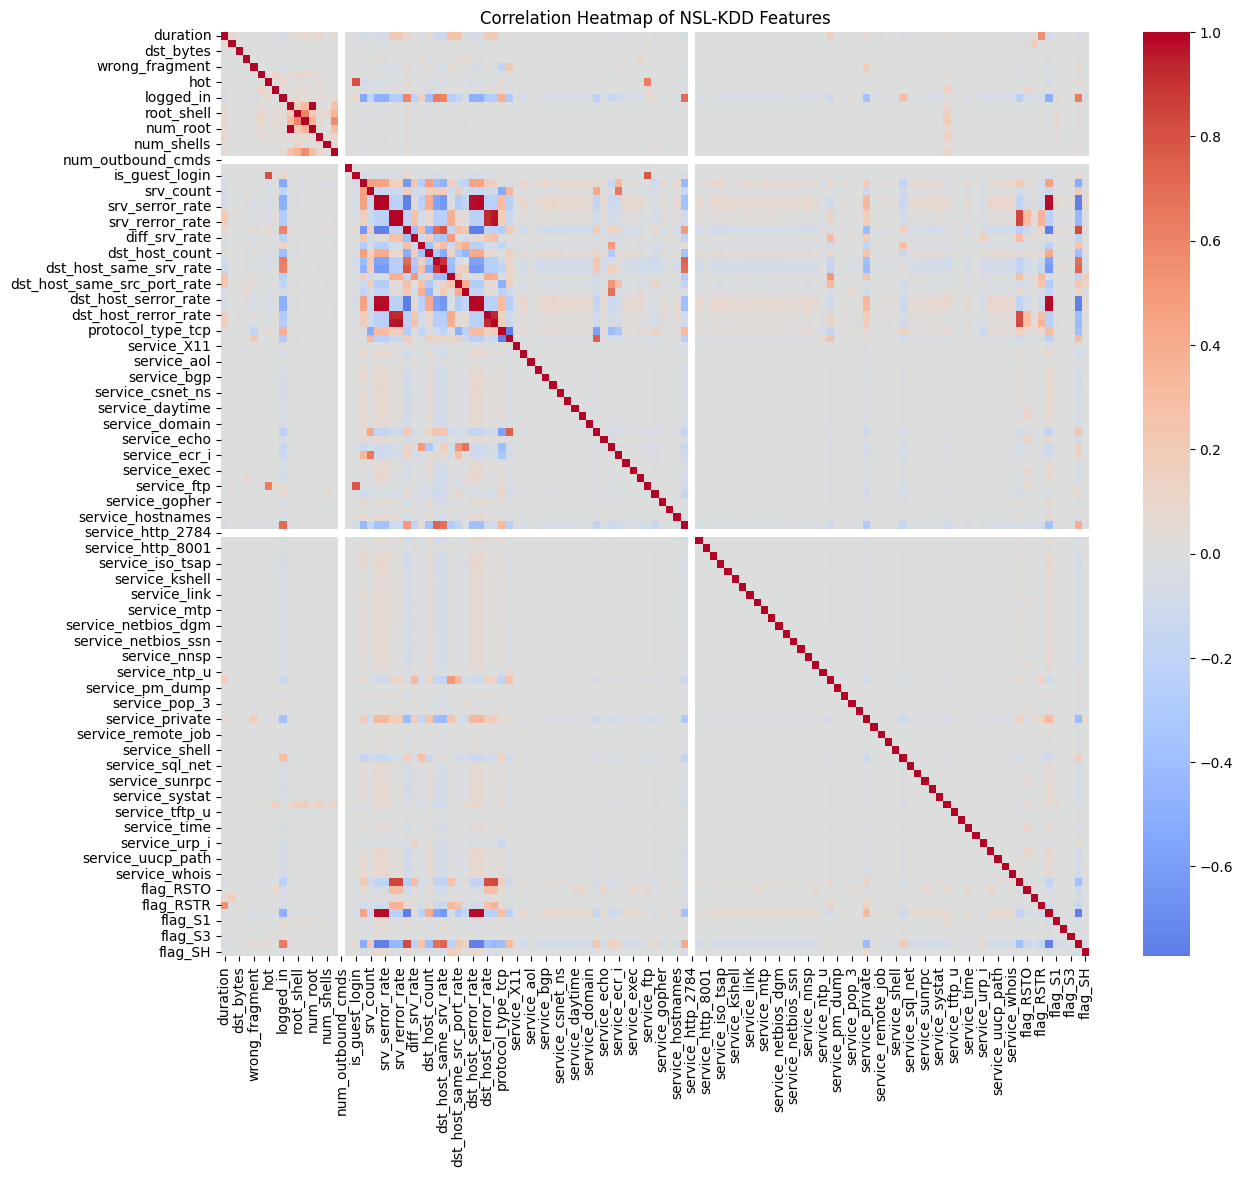

In [33]:
plt.figure(figsize=(14, 12))
corr = X_train.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt=".2f", cbar=True)
plt.title('Correlation Heatmap of NSL-KDD Features')
plt.show()
